In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) #show number of GPUs
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
#from dl1_data_handler.reader import DL1DataReaderSTAGE1, DL1DataReaderDL1DH
import h5py
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' #for compatability?
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

#this code makes Nvidia RTX3080 also compatible with the code
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

"""
This code was tested with:
40Gb Ram
2x Nvidia RTX2080ti
numpy 1.19.2
scipy 1.7.3
six 1.15.0
tensorflow-gpu 2.4.0
cudnn 8.0.5.39
cudatoolkit 11.0.3
python 3.8.3

run yourself:
. /home/hpc/caph/mppi109h/miniconda3/etc/profile.d/conda.sh
cd /home/hpc/caph/mppi109h
conda activate cuda11
"""


def unison_shuffled_copies(a, b):
    """shuffle proton/gamma images and proton/gamma labels the same way"""
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p] , b[p]


2022-01-28 20:05:55.999354: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-28 20:06:01.298320: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-28 20:06:01.300720: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-28 20:06:01.423951: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:b1:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.71GHz coreCount: 68 deviceMemorySize: 9.78GiB deviceMemoryBandwidth: 707.88GiB/s
2022-01-28 20:06:01.424669: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:b2:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.71GHz coreCount: 68 deviceMemorySize: 9.78GiB deviceMemoryBandwidth: 707.88GiB/s
2

Num GPUs Available:  2


2022-01-28 20:06:02.980275: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-28 20:06:02.981531: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-28 20:06:03.207493: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:b1:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.71GHz coreCount: 68 deviceMemorySize: 9.78GiB deviceMemoryBandwidth: 707.88GiB/s
2022-01-28 20:06:03.208192: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:b2:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.71GHz coreCount: 68 deviceMe

In [2]:
#load training images from h5 data on woody:

hillas_threshold = 800 #minimum hillas intensity that an image must have to be considered for training

#load .h5 gamma events from dmitry and convert to npy for training
filename = "/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_square_images/gamma-diffuse_50000_images.h5"
with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data = list(f[a_group_key])
    print(f["image"].shape)
    gamma_images = np.array(f["image"]).astype("float32")
    
    #extract data with hillas intensity > hillas_threshold
    hillas = np.array(f["hillas_intensity"]) #hillas intensity for every image)
    print(hillas.shape)
    hillas_400_index = np.squeeze(np.argwhere(hillas > hillas_threshold))
    print(hillas_400_index.shape)
    


#load .h5 proton events from dmitry and convert to npy for training
filename2 = "/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_square_images/proton_50000_images.h5"
with h5py.File(filename2, "r") as f2:
    # List all groups
    print("Keys: %s" % f2.keys())
    a_group_key = list(f2.keys())[0]

    # Get the data
    data2 = list(f2[a_group_key])
    print(f2["image"].shape)
    proton_images = np.array(f2["image"]).astype("float32")
    
    #extract data with hillas intensity > hillas_threshold
    hillas = np.array(f2["hillas_intensity"]) #hillas intensity for every image)
    print(hillas.shape)
    hillas_400_index = np.squeeze(np.argwhere(hillas > hillas_threshold))
    print(hillas_400_index.shape)


Keys: <KeysViewHDF5 ['hillas_intensity', 'hillas_kurtosis', 'hillas_length', 'hillas_phi', 'hillas_psi', 'hillas_r', 'hillas_skewness', 'hillas_width', 'hillas_x', 'hillas_y', 'image', 'image_mask', 'morphology_num_large_islands', 'morphology_num_medium_islands', 'morphology_num_pixels', 'true_alt', 'true_az', 'true_energy']>
(50000, 110, 110)
(50000,)
(7814,)
Keys: <KeysViewHDF5 ['hillas_intensity', 'hillas_kurtosis', 'hillas_length', 'hillas_phi', 'hillas_psi', 'hillas_r', 'hillas_skewness', 'hillas_width', 'hillas_x', 'hillas_y', 'image', 'image_mask', 'morphology_num_large_islands', 'morphology_num_medium_islands', 'morphology_num_pixels', 'true_alt', 'true_az', 'true_energy']>
(50000, 110, 110)
(50000,)
(8757,)


In [3]:
#gamma_images = gamma_images[hillas_400_index] #apply hillas-mask to gamma_images for training
print(gamma_images.shape)

    
#proton_images = proton_images[hillas_400_index]    
print(proton_images.shape)

(50000, 110, 110)
(50000, 110, 110)


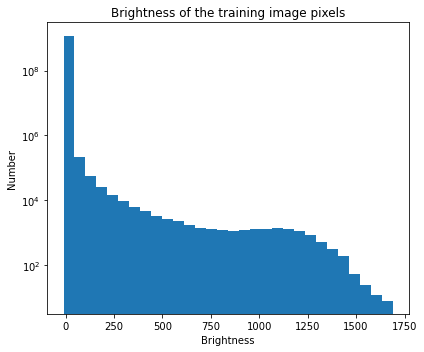

(100000,)


In [4]:
#prepare for training and testing
images_whole = np.concatenate((gamma_images, proton_images))
#images_whole = images_whole/np.amax(images_whole) #scale data/images (does not work currently)

# Creating histogram for dataset images_whole
fig, axs = plt.subplots(1, 1, figsize =(6, 5), tight_layout = True)
axs.hist(images_whole.flatten(), bins = 30, log = True)
axs.set_title("Brightness of the training image pixels")
plt.ylabel("Number")
plt.xlabel("Brightness")
plt.show()


proton_label = np.ones(np.size(proton_images,0)) #protons should have label (1,0)
gamma_label = np.zeros(np.size(gamma_images,0)) #gammas should have label (0,1)
labels_whole = np.concatenate((proton_label, gamma_label))
#labels_whole = np.stack((labels_whole, np.flipud(labels_whole)), axis = 1).astype(int) #make labels one hot encoding
print(labels_whole.shape)

#shuffle training data
images, labels = unison_shuffled_copies(images_whole, labels_whole) #does function work on axis 0 for images?

#make train/test split
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.05, random_state=42)

#prepare for neural network input
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

/tmp/ipykernel_490930/2977957837.py:10: DeprecationWarning: This function is deprecated. Please call randint(0, 3000 + 1) instead
  rand = np.random.random_integers(0,3000)


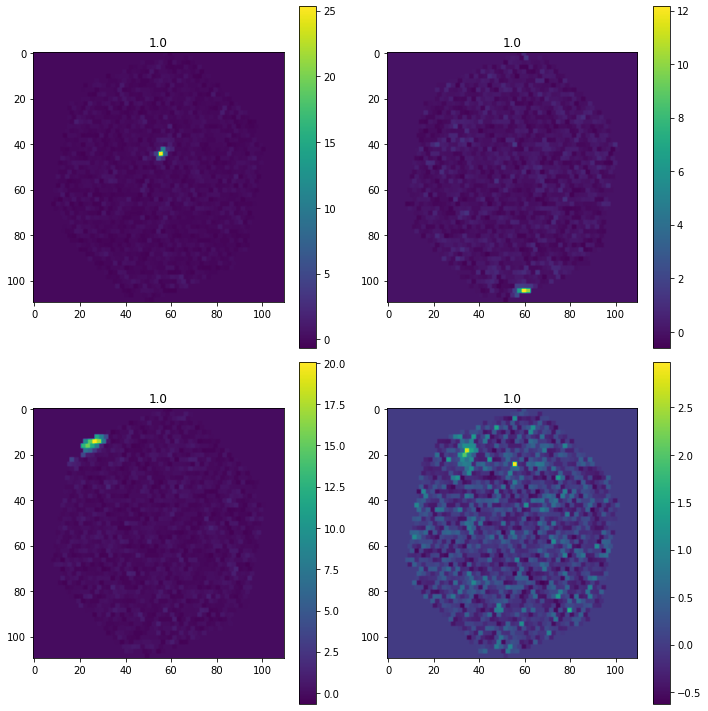

In [5]:
#print random examples of proton events to see how the data looks like
width=5
height=5
rows = 2
cols = 2
axes=[]
fig=plt.figure(figsize=(10, 10))

for a in range(rows*cols):
    rand = np.random.random_integers(0,3000)
    b = images_whole[a+rand,:,:]
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Subplot"+str(a))
    axes[-1].set_title(labels_whole[a+rand])  
    plt.imshow(b)
    plt.colorbar()
fig.tight_layout()    
plt.show()

(100000, 110, 110)


/tmp/ipykernel_490930/2973811445.py:11: DeprecationWarning: This function is deprecated. Please call randint(0, 3000 + 1) instead
  rand = np.random.random_integers(0,3000)


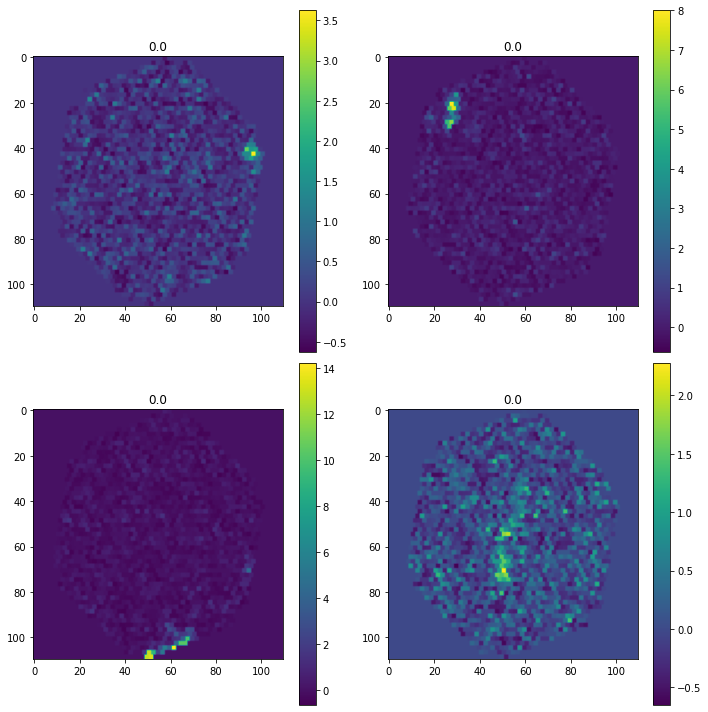

In [6]:
#print random examples of gamma events to see how the data looks like
width=5
height=5
rows = 2
cols = 2
axes=[]
fig=plt.figure(figsize=(10, 10))
print(images_whole.shape)

for a in range(rows*cols):
    rand = np.random.random_integers(0,3000)
    b = images_whole[np.size(gamma_images,0)+a+rand,:,:]
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Subplot"+str(a))
    axes[-1].set_title(labels_whole[np.size(gamma_images,0)+a+rand])  
    plt.imshow(b)
    plt.colorbar()
fig.tight_layout()    
plt.show()

In [8]:
#define training parameters
l2_rate = 0.5e-4
dropout_rate = 0.1
opt = tf.keras.optimizers.Adam() #learning_rate=0.0001

#define/crate neural network with layers
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 20, kernel_size = 4, padding='same', activation='relu', input_shape = (110,110,1), kernel_regularizer=tf.keras.regularizers.l2(l2=l2_rate)),
    tf.keras.layers.SpatialDropout2D(dropout_rate),
    tf.keras.layers.Conv2D(filters = 20, kernel_size = 4, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=l2_rate)),
    tf.keras.layers.SpatialDropout2D(0.05),
    tf.keras.layers.Conv2D(filters = 10, kernel_size = 2, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=l2_rate)),
    tf.keras.layers.SpatialDropout2D(0.05),
    tf.keras.layers.Conv2D(filters = 10, kernel_size = 2, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=l2_rate)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=l2_rate)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=l2_rate)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=l2_rate)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#compile neural network
model.compile(optimizer=opt , loss= 'binary_crossentropy', metrics=['accuracy'])

#train neural network
history = model.fit(train_images, train_labels, validation_split = 0.1, epochs=7)

#save model
#model.save("/home/woody/caph/mppi109h/keras-model-cnn")

print(model.summary()) #show structure of neural ntwork

Epoch 1/7
2672/2672 [==============================] - 46s 17ms/step - loss: 0.7275 - accuracy: 0.5100 - val_loss: 0.7141 - val_accuracy: 0.5532
Epoch 2/7
2672/2672 [==============================] - 45s 17ms/step - loss: 0.7105 - accuracy: 0.5688 - val_loss: 0.6493 - val_accuracy: 0.6520
Epoch 3/7
2672/2672 [==============================] - 45s 17ms/step - loss: 0.6559 - accuracy: 0.6432 - val_loss: 0.6553 - val_accuracy: 0.6375
Epoch 4/7
2672/2672 [==============================] - 45s 17ms/step - loss: 0.6363 - accuracy: 0.6618 - val_loss: 0.6389 - val_accuracy: 0.6571
Epoch 5/7
2672/2672 [==============================] - 45s 17ms/step - loss: 0.6283 - accuracy: 0.6719 - val_loss: 0.6148 - val_accuracy: 0.6805
Epoch 6/7
2672/2672 [==============================] - 45s 17ms/step - loss: 0.6151 - accuracy: 0.6844 - val_loss: 0.6306 - val_accuracy: 0.6635
Epoch 7/7
2672/2672 [==============================] - 45s 17ms/step - loss: 0.6104 - accuracy: 0.6851 - val_loss: 0.6105 - val_ac

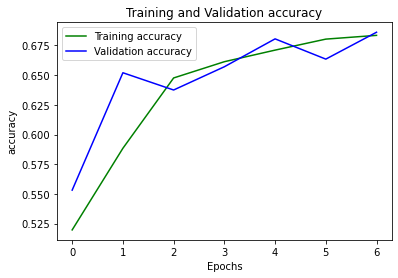

157/157 - 25s - loss: 0.6190 - accuracy: 0.6786

Test accuracy: 0.678600013256073


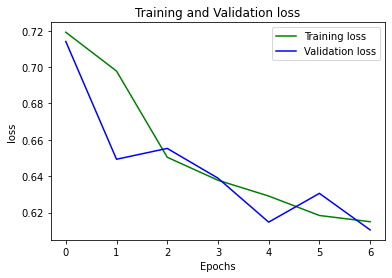

/home/hpc/caph/mppi109h/miniconda3/envs/cuda11/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


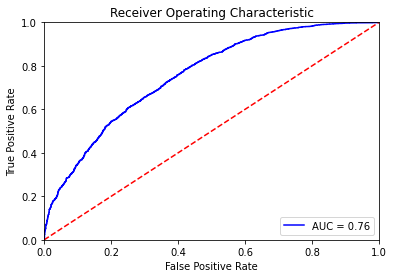

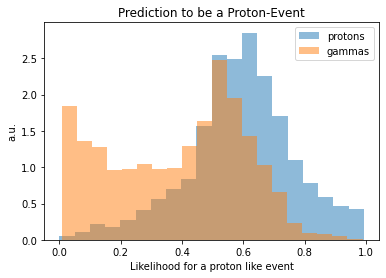

In [9]:
#Show results of training:

#show accuracy by epochs
print(history) 
plt.plot(history.history['accuracy'], 'g', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

#check accuracy with testimages
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)


#show loss by epochs
print(history) 
plt.plot(history.history['loss'], 'g', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


# calculate the fpr and tpr for all thresholds of the classification
predict_prob=model.predict_proba(test_images)
#fpr, tpr, threshold = metrics.roc_curve(np.argmax(test_labels, axis=1), predict_prob[:,1])
fpr, tpr, threshold = metrics.roc_curve(test_labels, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# show ROC plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#separation plot
test_index_proton = np.argwhere(test_labels==1)
test_index_gamma = np.argwhere(test_labels==0)
pred_proton = model.predict(test_images[np.squeeze(test_index_proton)])
pred_gamma = model.predict(test_images[np.squeeze(test_index_gamma)])

plt.hist(pred_proton, bins=20, alpha=0.5, label="protons", density=True)
plt.hist(pred_gamma, bins=20, alpha=0.5, label="gammas", density=True)
plt.xlabel("Likelihood for a proton like event")
plt.ylabel("a.u.")
plt.title("Prediction to be a Proton-Event")
plt.legend()
plt.show()

In [ ]:
#nothing important down here

In [ ]:
#this model achieved more than 66% accuracy and 0.71 AUC in the ROC plot after 8 epochs (100k images)
"""
#define training parameters
l2_rate = 0.5e-4
dropout_rate = 0.1


#define/crate neural network with layers
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 20, kernel_size = 2, padding='same', activation='relu', input_shape = (110,110,1), kernel_regularizer=tf.keras.regularizers.l2(l2=l2_rate)),
    tf.keras.layers.SpatialDropout2D(dropout_rate),
    tf.keras.layers.Conv2D(filters = 20, kernel_size = 2, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=l2_rate)),
    tf.keras.layers.SpatialDropout2D(0.05),
    tf.keras.layers.Conv2D(filters = 10, kernel_size = 2, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=l2_rate)),
    tf.keras.layers.SpatialDropout2D(0.05), #dropout = 0.1 here leads to no training?
    tf.keras.layers.Conv2D(filters = 10, kernel_size = 2, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=l2_rate)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=l2_rate)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=l2_rate)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=l2_rate)),
    tf.keras.layers.Dense(2, activation='softmax')
])
"""

"""" #training on multiple gpus
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
"""

In [ ]:
# example derived from /home/woody/caph/mpp228/ML/CTA/dl1-data-handler_stage1/notebooks/dl1reading_stage1.ipynb

def descend_obj(obj, sep='\t', res_str=''):
    """
    Iterate through groups in a HDF5 file and prints the groups and 
    datasets names and datasets attributes
    """
    if type(obj) in [h5py._hl.group.Group, h5py._hl.files.File]:
        for key in obj.keys():
            try:
                res_str += '%s-%s: %s\n' % (sep, key, obj[key])
            except:
                res_str += '%s-%s: %s\n' % (sep, key, 'problem:(')
            res_str = descend_obj(obj[key], sep=sep+sep, res_str=res_str)
    elif type(obj)==h5py._hl.dataset.Dataset:
        for key in obj.attrs.keys():
            try:
                res_str += '%s+%s: %s\n' % (sep+sep, key, obj.attrs[key])
            except:
                res_str += '%s+%s: %s\n' % (sep+sep, key, 'problem here')
    return res_str

mode = 'mlgrid_gamma-diffuse' #'mlgrid_proton', 'mlgrid_gamma-diffuse'
if mode == 'mlgrid_proton':
    folder = '/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/'
    folder += 'Prod5_Paranal_AdvancedBaseline_NSB1x_proton_North_20deg_ctapipe_v0.10.5_DL1/'
    fn0 = 'proton_20deg_0deg_run14656___cta-prod5-paranal_desert-2147m-Paranal-dark_merged.DL1.h5'
elif mode == 'mlgrid_gamma-diffuse':
    folder = '/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/'
    folder += 'Prod5_Paranal_AdvancedBaseline_NSB1x_gamma-diffuse_North_20deg_ctapipe_v0.10.5_DL1/'
    fn0 = 'gamma_20deg_0deg_run5996___cta-prod5-paranal_desert-2147m-Paranal-dark_cone10_merged.DL1.h5'
fn = folder + fn0


test = DL1DataReaderSTAGE1(["/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_square_images/proton_50000_images.h5"],
                                 mode='mono',
                                 #example_identifiers_file="./examples.h5",
                                 selected_telescope_types=["LST_LST_LSTCam"],
                                 selected_telescope_ids = {"LST_LST_LSTCam": [1]},
                                 image_channels = ['image', 'peak_time', 'image_mask'],
                                 parameter_list = ['hillas_intensity', 'hillas_x'],
                                 event_info = ["true_energy", "true_alt", "true_az"])



#test_path = fn2reader("/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_Paranal_AdvancedBaseline_NSB1x_gamma-diffuse_North_20deg_ctapipe_v0.10.5_DL1")
print(test)